In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
li = [[],[],[]]
for i, subfolder in zip(range(3), ['RAD', 'gt', 'stereo_image']):
    for filename in os.listdir('/kaggle/input/carrada/test/' + str(subfolder)):
            li[i].append(os.path.join('/kaggle/input/carrada/test/' + str(subfolder), filename))
            li[i].sort()
df = pd.DataFrame({'rad':li[0], 'gt':li[1], 'images':li[2]})


imageid_bbox_label = [[], [], []]
for file in li[1]:
    for x in ['classes', 'boxes']:
        file_content = pd.read_pickle(file)
        for i in range(len(file_content[x])):
            if x == 'classes':
                imageid_bbox_label[0].append(file.split('/')[-1][:-7])
                imageid_bbox_label[1].append(file_content[x][i])  
            else:
                x1 = file_content[x][i][0] - int(0.5 * (file_content[x][i][3]))
                y = file_content[x][i][1] - int(0.5 * (file_content[x][i][4]))
                w = file_content[x][i][3] 
                h = file_content[x][i][4]
                xywh = [x1, y, w, h]  #get only xyxy instead of xyzwhd
                imageid_bbox_label[2].append(xywh)
df = pd.DataFrame(imageid_bbox_label).T
df = df.rename(columns={0:'imageid',1:'label',2:'bbox'})
data = df.copy()
classes = {'truck':4, 'car':2, 'person':3, 'bicycle':0, 'bus':1}
df.label.replace(classes, inplace=True)

/tmp/ipykernel_34/905451680.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.label.replace(classes, inplace=True)
/tmp/ipykernel_34/905451680.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.label.replace(classes, inplace=True)


In [19]:
data.head(4) 

,imageid,label,bbox
0,000090,truck,"[132.5, 92.5, 28.0, 30.0]"
1,000090,truck,"[16.0, 163.0, 9.0, 11.0]"
2,000156,car,"[79.5, 163.0, 8.0, 11.0]"
3,000156,car,"[175.0, 123.5, 27.0, 40.0]"


In [20]:
print(f'Data contain {len(data.imageid.unique())} frame \nMaximum No. objects founded in a frame is: {data.imageid.value_counts().iloc[0]} objects')

Data contain 32 frame 
Maximum No. objects founded in a frame is: 5 objects


<BarContainer object of 5 artists>

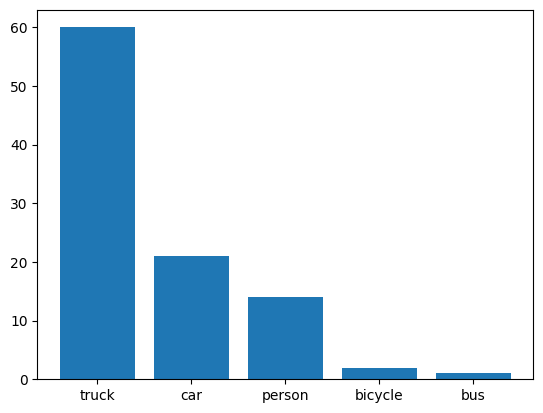

In [21]:
plt.bar(data['label'].unique(), data.label.value_counts().tolist())

In [2]:
def prepare_bbox(ip):
    return [ip[0], ip[1], ip[2], ip[3], ip[4], ip[5]]
x, y, z, w, h, d = [], [], [], [], [], []
for u in df.bbox.apply(prepare_bbox):
    x.append(u[0])
    y.append(u[1])
    z.append(u[2])
    w.append(u[3])
    h.append(u[2])
    d.append(u[3])
data = pd.DataFrame()
data = df
data['x'] = x
data['y'] = y
data['z'] = z
data['w'] = w
data['h'] = h
data['d'] = d
data.drop(['bbox'], axis=1, inplace =True)
data.head(2)

NameError: name 'df' is not defined

# Detectron2

In [3]:
!nvidia-smi

Thu Apr 18 20:58:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

2.1.2 True


In [5]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-h_5csaut
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-h_5csaut
  Resolved https://github.com/facebookresearch/detectron2.git to commit a59f05630a8f205756064244bf5beb8661f96180
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57

In [6]:
!python -m detectron2.utils.collect_env

-------------------------------  ------------------------------------------------------------------------------
sys.platform                     linux
Python                           3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
numpy                            1.26.4
detectron2                       0.6 @/opt/conda/lib/python3.10/site-packages/detectron2
Compiler                         GCC 9.4
CUDA compiler                    CUDA 12.1
detectron2 arch flags            7.5
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          2.1.2 @/opt/conda/lib/python3.10/site-packages/torch
PyTorch debug build              False
torch._C._GLIBCXX_USE_CXX11_ABI  True
GPU available                    Yes
GPU 0,1                          Tesla T4 (arch=7.5)
Driver version                   535.129.03
CUDA_HOME                        /usr/local/cuda
Pillow                           9.5.0
torchvision                      0.16.2 @/opt/conda/lib/pyt

## libraries

In [7]:
# import some common libraries
import numpy as np
import os, json, cv2, random
import skimage.io as io
import pylab
import sys
import copy
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image


# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Set base params
#plt.rcParams["figure.figsize"] = [16,9]

# 

# 

In [8]:
dataset_dir = ".../kaggle/input/carrada"
train_dir = "/test"

In [9]:
class preprocessing:
    def magnitude(self, target_array):
        """ get magnitude out of complex number """
        target_array = np.abs(target_array)
        target_array = pow(target_array, 2)
        return target_array 

    def log(self, target_array):
        """ get Log values """
        return  10 * np.log10(target_array + 1.)


    def summation(self, target_array, target_axis):
        """ sum up one dimension """
        output = np.sum(target_array, axis=target_axis)
        return output
    
    def process(self, spectrum):
        """ Return spectrum """
        return self.complex_to_channel(spectrum)
    
    def complex_to_channel(self, target_array):
        """ transfer complex a + bi to [a, b] """
        assert target_array.dtype == np.complex64
        output_array = self.magnitude(target_array)
        output_array = self.log(output_array)
        return output_array
    
    def extract_RA(self, target_array):
        """ Project 3D into 2D """
        return self.log(self.summation(self.magnitude(target_array), target_axis=-1))

In [25]:
from detectron2.data import MetadataCatalog, DatasetCatalog

class data(preprocessing):
    def __init__(self, df):
        self.df = df
        self.ids =  df.imageid.unique().tolist()
        self.find_min_max()

        
    def find_min_max(self):
        """ Find min and max in whole data """
        global_min = np.inf
        global_max = -np.inf
        
        for img_id in self.ids:
            path = os.path.join('/kaggle/input/carrada/test/RAD', img_id + '.npy')
            spectrum = np.load(path)
            spectrum = self.process(spectrum)
            temp_min = np.min(spectrum)
            temp_max = np.max(spectrum)
            if temp_max > global_max:
                global_max = temp_max
            if temp_min < global_min:
                global_min = temp_min
        self.global_min = global_min
        self.global_max = global_max

        
    def transforms(self, spectrum):
        """ Return normalized image """
        return (spectrum-self.global_min)/(self.global_max-self.global_min)
    
 
    def __len__(self):
        """ Return number of frames """
        return len(self.ids)
    
    def __getitem__(self, idx):
        spectrum = np.load('/kaggle/input/carrada/test/RAD/' + str(self.ids[idx]) + '.npy')
        
        
        
        # NOTE: Gloabl Normalization
        spectrum = self.extract_RA(spectrum)
#         spectrum = self.process(spectrum)     #for RAD
        spectrum = self.transforms(spectrum)
        spectrum = torch.as_tensor(spectrum[None, :, :], dtype=torch.float32)
#         spectrum = torch.from_numpy(spectrum)
        labels = self.df['label'][self.df['imageid'] == self.ids[idx]].tolist()
        labels = torch.as_tensor(labels, dtype=torch.int64)      
        boxes = self.df['bbox'][self.df['imageid'] == self.ids[idx]].tolist()
        boxes = torch.as_tensor(boxes)
        
        li = []
        for x in range(len(labels)):
            anna = {}
            anna['bbox'] = boxes[x]
            anna['category_id'] = labels[x]
            anna["bbox_mode"] = 1
            li.append(anna)
        
        data_dict = {}
        data_dict["image"] = spectrum.float()
#         data_dict["annotations"] = li
        data_dict["boxes"] = boxes
        data_dict["labels"] = labels
        data_dict["file_name"] = '/kaggle/input/carrada/test/RAD/' + str(self.ids[idx]) + '.npy'
        data_dict["width"] = spectrum.shape[0]
        data_dict["height"] = spectrum.shape[1]
        
        
        return data_dict
    
def loader():
    return data(df) 

In [23]:
DatasetCatalog.register("train", loader)
metadata_dicts = MetadataCatalog.get("train").set(thing_classes=["person", "bicycle", "car", "motorcycle", "bus", "truck"])

In [26]:
dataset_dicts = DatasetCatalog.get('train')

In [27]:
d = copy.deepcopy(dataset_dicts)

In [29]:
d[0]['image'].shape

torch.Size([1, 256, 256])

## Visualization

In [ ]:
fig, ax = plt.subplots(2, 2, figsize =(20,14))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
for d in random.sample(dataset_dicts, 4):
    i=i+1    
#     img = cv2.imread(d["image_id"])
    spectrum = np.load('')
    v = Visualizer(img[:, :, ::-1],
                   metadata=metadata_dicts, 
                   scale=0.4, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    indices[i].grid(False)
    indices[i].axis('off')
    indices[i].imshow(out.get_image()[:, :, ::-1])

# 

# 

## Training

In [30]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T

def custom_mapper(dataset_dict):
#     dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    # can use other ways to read image
#     annos = [
#         annotation
#         for annotation in dataset_dict.pop("annotations")
#     ]
    
#     dataset_dict["instances"] = utils.annotations_to_instances(annos, (256,256))
   
    return dataset_dict
class AugTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [32]:
cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml" 
# config_name = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))

cfg.DATASETS.TRAIN = ("train",)
# cfg.DATASETS.TEST = ("val",)
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 3500  #adjust up if val mAP is still rising, adjust down if overfit
#cfg.SOLVER.STEPS = (100, 500) # must be less than  MAX_ITER 
#cfg.SOLVER.GAMMA = 0.05


cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


#Training using custom trainer defined above
trainer = AugTrainer(cfg) 
# trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/18 21:04:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

AssertionError: RPN requires gt_instances in training!

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# torch

In [104]:
import torch
import torchvision

In [ ]:
class CusDat(torch.utils.data.Dataset):
    def __init__(delf, df, unique_imgs, indices):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        image_name = self.unique_imgs[self.indices[idx]]
        boxes = self.df[self.df.image_id == image_name].values[:, 1:].astype('float')
        img = Image.apen(".../kaggle/input/carrada/test/stereo_image/"+ image_name + ".jpg").convert('RGB')
        labels = torch.ones((boxes.shape[0]), dtype = torch.int64)
        target = {}
        target['boxes'] = torch.tensor(boxes)
        target['label'] = labels
        return torchvision.transforms.ToTensor()(img), target

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
num_classes = 7
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# YOLO

In [ ]:
! git clone https://github.com/ultralytics/yolov5.git
! cd yolov5
! pip install -r requirements.txt

In [ ]:
! python train.py --img 640 --batch 16 --epochs 50 --data data.yaml --cfg models/yolov5s.yaml --weights '' --name custom_dataset

In [ ]:
! python val.py --img 640 --data data.yaml --weights runs/train/custom_dataset/weights/best.pt

In [ ]:
! python train.py --img 640 --batch 16 --epochs 100 --data data.yaml --cfg models/yolov5s.yaml --weights runs/train/custom_dataset/weights/last.pt --name custom_dataset_ft

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# TensorFlow

In [4]:
import tensorflow as tf

2024-04-16 19:41:39.444774: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 19:41:39.444887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 19:41:39.580280: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# parameters from the paper: Range-Azimuth-Doppler based Radar Object Detectionfor Dynamic Road Users paper 
# These param. can't be used because TINY PORTION of dataset will be trained
# parameters = {"global_mean_log" : 3.2438383, "global_max_log" : 10.0805629, "global_min_log" : 0.0, "global_variance_log" : 6.8367246, "designed_frequency" : 76.8,"config_frequency" : 77,"range_size" : 256,"doppler_size" : 64,"azimuth_size" : 256,"range_resolution" : 0.1953125,"angular_resolution" : 0.006135923,"velocity_resolution" : 0.41968030701528203}

In [6]:
def readRAD(filename):
    """ read input RAD matrices """
    if os.path.exists(filename):
        return np.load(filename)
    else:
        return None

def gtfileFromRADfile(RAD_file, prefix):
    """ Transfer RAD filename to gt filename """
    RAD_file_spec = RAD_file.split("RAD")[-1]
    gt_file = os.path.join(prefix, "gt") + RAD_file_spec.replace("npy", "pickle")
    return gt_file
 
def imgfileFromRADfile(RAD_file, prefix):
    """ Transfer RAD filename to gt filename """
    RAD_file_spec = RAD_file.split("RAD")[-1]
    gt_file = os.path.join(prefix, "stereo_image") + RAD_file_spec.replace("npy", "jpg")
    return gt_file



def readRadarInstances(pickle_file):
    """ read output radar instances. """
    if os.path.exists(pickle_file):
        with open(pickle_file, "rb") as f:
            radar_instances = pickle.load(f)
        if len(radar_instances['classes']) == 0:
            radar_instances = None
    else:
        radar_instances = None
    return radar_instances
   
def readStereoLeft(img_filename):
    """ read stereo left image for verification. """
    if os.path.exists(img_filename):
        stereo_image = cv2.imread(img_filename)
        left_image = stereo_image[:, :stereo_image.shape[1]//2, ...][..., ::-1]
        return left_image
    else:
        return None
    
def readSingleImage(img_filename):
    """ read stereo left image for verification. """
    if os.path.exists(img_filename):
        image = cv2.imread(img_filename)
        image = image[..., ::-1]
        return image
    else:
        return None

In [8]:
def normalization(file_name):
    RAD_data = np.load(file_name)
    RAD_complex = readRAD(RAD_filename)
    # normalize whole data
    RAD_data = complexTo2Channels(RAD_complex)
    normalized_RAD = (RAD_data - parameteres["global_mean_log"]) / parameteres["global_variance_log"]
    
    # return normalized data
    return normalized_RAD


def cartesian_to_polar(x, y):
    """ Cartesian to Polar """
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def polar_to_cartesian(rho, phi):
    """ Polar to Cartesian """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def complexTo2Channels(target_array):
    """ transfer complex a + bi to [a, b]"""
    assert target_array.dtype == np.complex64
    ### NOTE: transfer complex to (magnitude) ###
    output_array = magnitude(target_array)
    output_array = log(output_array)
    return output_array

def magnitude(target_array):
    """ get magnitude out of complex number """
    target_array = np.abs(target_array)
    target_array = pow(target_array, 2)
    return target_array 

def log(target_array):
    """ get Log values """
    return  10 * np.log10(target_array + 1.)


def sum(target_array, target_axis):
    """ sum up one dimension """
    output = np.sum(target_array, axis=target_axis)
    return output

def extract_RA(file_name):
    RAD = normalization(file_name).T
    RA = np.log(np.abs(RAD).sum(axis=0))
    return RA.T

def extract_RD(file_name):
    RAD = normalization(file_name)
    RD = np.log(np.abs(RAD).sum(axis=0))
    return RD

def extract_DoA(file_name):
    RA = extract_RA(file_name) 
    return polar_to_cartesian(RA)

def readRAD(filename):
    if os.path.exists(filename):
        return np.load(filename)
    else:
        return None
    
# RAD = readRAD('/kaggle/input/carrada/test/RAD/000156.npy')

# RA = getLog(getSumDim(getMagnitude(RAD, power_order=2), target_axis=-1), scalar=10, log_10=True)
# RD = getLog(getSumDim(getMagnitude(RAD, power_order=2), target_axis=1), scalar=10, log_10=True)

In [ ]:
 def encodeToLabels(gt_instances):
        """ Transfer ground truth instances into Detection Head format """
        raw_boxes_xyzwhd = np.zeros((30, 7)) # 30 is the max number of boxes in frame 
        
        ### initialize gronud truth labels as np.zeors ###
        gt_labels = np.zeros(list(self.headoutput_shape[1:4]) + [len(self.anchor_boxes)] + [len(classes["all_classes"]) + 7])
        
        classes = {"all_classes" : ["person", "bicycle", "car", "motorcycle", "bus", "truck" ]}
        ### start transferring box to ground turth label format ###
        for i in range(len(gt_instances["classes"])):
            if i > 30:
                continue
            class_name = gt_instances["classes"][i]
            box_xyzwhd = gt_instances["boxes"][i]
            class_id = classes["all_classes"].index(class_name)
            if i < 30:
                raw_boxes_xyzwhd[i, :6] = box_xyzwhd
                raw_boxes_xyzwhd[i, 6] = class_id
            class_onehot = helper.smoothOnehot(class_id, len(self.config_data["all_classes"]))
            
            exist_positive = False

            grid_strid = np.array(np.array(self.config_model["input_shape"])[:3] / np.array(self.headoutput_shape[1:4])).astype(np.float32)
            anchor_stage = self.anchor_boxes
            box_xyzwhd_scaled = box_xyzwhd[np.newaxis, :].astype(np.float32)
            box_xyzwhd_scaled[:, :3] /= grid_strid
            anchorstage_xyzwhd = np.zeros([len(anchor_stage), 6])
            anchorstage_xyzwhd[:, :3] = np.floor(box_xyzwhd_scaled[:, :3]) + 0.5
            anchorstage_xyzwhd[:, 3:] = anchor_stage.astype(np.float32)

            iou_scaled = helper.iou3d(box_xyzwhd_scaled, anchorstage_xyzwhd, self.input_size)
            ### NOTE: 0.3 is from YOLOv4, maybe this should be different here ###
            ### it means, as long as iou is over 0.3 with an anchor, the anchor
            ### should be taken into consideration as a ground truth label
            iou_mask = iou_scaled > 0.3

            if np.any(iou_mask):
                xind, yind, zind = np.floor(np.squeeze(box_xyzwhd_scaled)[:3]).astype(np.int32)
                ### TODO: consider changing the box to raw yolohead output format ###
                gt_labels[xind, yind, zind, iou_mask, 0:6] = box_xyzwhd
                gt_labels[xind, yind, zind, iou_mask, 6:7] = 1.
                gt_labels[xind, yind, zind, iou_mask, 7:] = class_onehot
                exist_positive = True

            if not exist_positive:
                ### NOTE: this is the normal one ###
                ### it means take the anchor box with maximum iou to the raw
                ### box as the ground truth label
                anchor_ind = np.argmax(iou_scaled)
                xind, yind, zind = np.floor(np.squeeze(box_xyzwhd_scaled)[:3]).astype(np.int32)
                gt_labels[xind, yind, zind, anchor_ind, 0:6] = box_xyzwhd
                gt_labels[xind, yind, zind, anchor_ind, 6:7] = 1.
                gt_labels[xind, yind, zind, anchor_ind, 7:] = class_onehot

        has_label = False
        for label_stage in gt_labels:
            if label_stage.max() != 0:
                has_label = True
        gt_labels = [np.where(gt_i == 0, 1e-16, gt_i) for gt_i in gt_labels]
        return gt_labels, has_label, raw_boxes_xyzwhd

In [ ]:
def trainData():
    """ Generate train data with batch size """
    count = 0
    paths =  glob.glob(os.path.join('/kaggle/input/carrada/test/', "RAD/*/*.npy"))'
    while  count < len(paths):
        RAD_filename = paths[count] 
        RAD_complex = readRAD(RAD_filename)

        ### NOTE: Gloabl Normalization ###
        RAD_data = helper.complexTo2Channels(RAD_complex)
        RAD_data = (RAD_data - self.config_data["global_mean_log"]) / self.config_data["global_variance_log"]
        
        ### load ground truth instances ###
        gt_instances = readRadarInstances(gtfileFromRADfile(RAD_filename, '/kaggle/input/carrada/test/'))
        
        ### NOTE: decode ground truth boxes to YOLO format ###
        gt_labels, has_label, raw_boxes = encodeToLabels(gt_instances)

        if has_label:
            yield (RAD_data, gt_labels, raw_boxes)
            
        count += 1
        if count == len(paths) - 1:
            np.random.shuffle(paths)

def trainGenerator():
    """ Building data generator using tf.data.Dataset.from_generator """
    return tf.data.Dataset.from_generator(self.trainData, output_types=(tf.float32, tf.float32, tf.float32), output_shapes=(256, 256, 64), tf.TensorShape(list(self.headoutput_shape[1:4]) + [len(self.anchor_boxes), 7+len(self.config_data["all_classes"])]), tf.TensorShape(30, 7]) ), )


In [22]:
def process(RAD_filename):
    prefix = '/kaggle/input/carrada/test'
    RAD = readRAD(RAD_filename)
    gt_instances = readRadarInstances(gtfileFromRADfile(RAD_filename, prefix))
    stereo_left_image = loader.readStereoLeft(imgfileFromRADfile(RAD_filename, prefix))
    if RAD is not None and gt_instances is not None and stereo_left_image is not None:
        RA = log(summation(magnitude(RAD), target_axis=-1))
        RD = log(summation(magnitude(RAD), target_axis=1))
    return RAD, gt_instances, stereo_left_image, RA, RD


all_RAD_files = glob(os.path.join('/kaggle/input/carrada/test/', "RAD/*/*.npy"))
print('start')
for i in tqdm.tqdm(range(len(all_RAD_files[:5]))):
    print(i)
    RAD_filename = all_RAD_files[i]
    RAD, gt_instances, stereo_left_image, RA, RD = process(RAD_filename)

start


0it [00:00, ?it/s]


In [ ]:
train = trainGenerator

# YoloV5

In [27]:
!mkdir '/kaggle/working/data/label'

In [36]:
df = pd.DataFrame()
df['format'] = data.imageid


for i in range(df.shape[0]):
    df.loc[i, 'format'] = '/kaggle/input/carrada/test/RAD/' + df['format'][i]
x = data.imageid[0]
for num_findings in data.imageid.value_counts().loc[x]:
    for img in range(df.shape[0]):
        file_name = df.loc[img, 'format']
        dx = pd.DataFrame()
        dx['format'][num_findings] = df['format'][img] + ',' + str(data.x[img]) + ',' + str(data.y[img]) + ',' + str(data.z[img]) + ',' + str(data.w[img]) + ',' + str(data.h[img]) + ',' + str(data.d[img]) + ',' + str(data.label[img]) 
        print(dx)
        x = data.imageid[i]
        i+=1
        break
    dx.to_csv('/kaggle/working/data/label/' + file_name.split('/')[-1] + '.txt', header=None, index=None, sep=' ')

                                              format
0  /kaggle/input/carrada/test/RAD/000090,146.5,10...


# 

# 

# 

# 